基于MINST数据库，设计和训练CNN，识别手写体数字
用尽量简单的结构，获得最优性能（>97%准确率）
在不增加总的可调权值系数的前提下，可对网络结构做修
改 (如：加深)（系数≤9x9x20+2000x100+100x10）
可采用SGD、批量、小批量、动量等算法。
编程语言不限，但必须有具体训练步骤（每层8的计算代码）
不借助任何机器或深度学习库
提交源代码+详细实验分析报告（包含：网络设计、训练
和调试方法、实验结果与分析比较，结论等）

In [48]:
import os
import random
import numpy as np
# import cupy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io as scio


In [49]:
class Linear:

    def __init__(self, in_feature, out_feature, bias=True):
        
        self.W = np.random.randn(in_feature, out_feature) * 0.01
        self.b = np.zeros((1, out_feature))
        
        self.bias = bias
        self.db = np.zeros((1, out_feature))
        self.params_size = self.W.size + self.b.size
        
    def forward(self, A_prev):
        self.A_prev = A_prev
        
        Z = A_prev @ self.W  + self.b
        
        # relu
        self.A = Z*(Z > 0)
        
        return self.A

    def backward(self, dZ_prev):

        A_prev = self.A_prev

        m = len(self.A)


        
        # relu flow back from dZ: dZ*1 if Z>0, dZ*0 otherwise
        self.dA = dZ_prev*(self.A > 0)

        self.dW = A_prev.T @ self.dA
        if self.bias: # update db only if True, else keep it zeros
            self.db = self.dA.sum(axis=0, keepdims=True)
        
        self.dZ = self.dA @ self.W.T
        
        return self.dZ


class Dropout:

    def __init__(self, dropout_rate=0.5):
        self.dropout_rate = dropout_rate
        self.A = None  
        self.dZ = None  

    def forward(self, A_prev, training=True):
        if training:
            self.A = A_prev
            self.dropout_mask = np.random.rand(*A_prev.shape) < self.dropout_rate
            A = A_prev * self.dropout_mask / self.dropout_rate
            return A
        else:
            return A_prev  

    def backward(self, dA):
        self.dZ = dA * self.dropout_mask / self.dropout_rate
        return self.dZ



# Test
if __name__ == '__main__':
    X = np.random.randn(2,4)
    net = Linear(4,2)
    A = net.forward(X)
    print(A.shape)
    print(net.backward(np.random.randn(2,2)))

(2, 2)
[[ 0.00323682  0.00024335  0.00481741  0.00587046]
 [-0.00895868 -0.00067353 -0.01333333 -0.0162479 ]]


In [50]:


class LinearSoftmaxLayer:
    """
    This class implements a combination of a linear layer and a softmax layer with ReLU activation.
    """

    def __init__(self, in_features, out_features):

        self.W = np.random.randn(in_features, out_features) * 0.01
        self.b = np.zeros((1, out_features))
        self.params_size = self.W.size + self.b.size

    def forward(self, A_prev):

        self.A_prev = A_prev
        Z = np.dot(A_prev, self.W) + self.b
        # ReLU activation
        A_relu = Z * (Z > 0)
        expA = np.exp(A_relu - np.max(A_relu, axis=-1, keepdims=True))
        self.A = expA / np.sum(expA, axis=-1, keepdims=True)
        return self.A

    def backward(self, dZ_prev):

        m = len(self.A)
        A_prev = self.A_prev
        self.dA = dZ_prev
        dA_relu = self.dA * (self.A > 0)  # Backpropagation for ReLU
        self.dW = np.dot(A_prev.T, dA_relu)
        self.db = np.sum(dA_relu, axis=0, keepdims=True)
        dA_prev = np.dot(dA_relu, self.W.T)
        return dA_prev




# 测试
if __name__ == '__main__':
    X = np.random.randn(2, 4)
    print(X)
    net = LinearSoftmaxLayer(4, 2)
    print(net.forward(X))
    print(net.backward(np.random.randn(2, 2)))


[[ 0.08175275  0.04348693 -0.27707589 -0.58146256]
 [-0.17684586 -3.22689962 -1.85369123  0.39231822]]
[[0.49989124 0.50010876]
 [0.51816236 0.48183764]]
[[-0.00410504  0.0031492   0.0073235  -0.00273026]
 [ 0.01183659 -0.01274867 -0.02727909  0.01060953]]


In [76]:
class PoolingLayer:
    """
    实现最大池化或平均池化层。
    """

    def __init__(self, filter_size, stride, mode='max'):
        """
        初始化池化层的超参数。
        
        参数:
        filter_size -- 池化过滤器的大小
        stride -- 池化的步长
        mode -- 池化模式，字符串类型，可以是"max"或"average"
        """
        self.filter_size = filter_size
        self.stride = stride
        self.mode = mode

    def forward(self, A_prev):
        """
        实现向前传播。
        
        参数:
        A_prev -- 输入数据，维度为(m, n_H_prev, n_W_prev, n_C_prev)
        
        返回:
        A -- 池化层的输出，维度为(m, n_H, n_W, n_C)
        """
        self.A_prev = A_prev
        m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
        f = self.filter_size
        stride = self.stride
        mode = self.mode

        n_H = int(1 + (n_H_prev - f) / stride)
        n_W = int(1 + (n_W_prev - f) / stride)
        n_C = n_C_prev

        A = np.zeros((m, n_H, n_W, n_C))

        for i in range(m):
            for h in range(n_H):
                vert_start = h * stride
                vert_end = vert_start + f
                for w in range(n_W):
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    for c in range(n_C):
                        a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                        if mode == "max":
                            A[i, h, w, c] = np.amax(a_prev_slice)
                        elif mode == "average":
                            A[i, h, w, c] = np.mean(a_prev_slice)

        assert(A.shape == (m, n_H, n_W, n_C))

        self.A = A
        return self.A

    def create_mask_from_window(self, x):
        mask = (x==np.max(x))
        return mask


    def distribute_value(self, dz, shape):
        (n_H, n_W) = shape
        average = dz/(n_H*n_W)
        a = np.zeros((n_H, n_W))+average
        return a

    def backward(self, dA, mode="max"):
    # 获取反向传播所需的参数
        A_prev = self.A_prev
        stride = self.stride
        f = self.filter_size

        # 获取输入的维度信息
        m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
        m, n_H, n_W, n_C = dA.shape

        # 初始化dA_prev
        dA_prev = np.zeros(A_prev.shape)

        for i in range(m):  # 遍历训练样本

            a_prev = A_prev[i]

            for h in range(n_H):  # 遍历垂直轴
                for w in range(n_W):  # 遍历水平轴
                    for c in range(n_C):  # 遍历通道（深度）

                        # 计算当前窗口的起始和结束位置
                        vert_start = h * stride
                        vert_end = vert_start + f
                        horiz_start = w * stride
                        horiz_end = horiz_start + f

                        if mode == "max":  # 最大池化模式

                            # 从输入中取出当前窗口
                            a_prev_slice = a_prev[vert_start: vert_end, horiz_start:horiz_end, c]

                            # 生成掩码
                            mask = self.create_mask_from_window(a_prev_slice)

                            # 将梯度乘以掩码并累加到dA_prev中
                            dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += mask * dA[i, h, w, c]

                        elif mode == "average":  # 平均池化模式

                            # 计算dA的值
                            da = dA[i, h, w, c]

                            # 计算窗口形状
                            shape = (f, f)

                            # 将dA的值平均分配到dA_prev中
                            dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += self.distribute_value(da, shape)

        # 确保dA_prev的形状与A_prev相同
        assert(dA_prev.shape == A_prev.shape)

        # 将计算得到的dA_prev赋值给self.dZ
        self.dZ = dA_prev

        return self.dZ

if __name__ == '__main__':
    # 测试
    X = np.random.randn(2, 28, 28, 1)
    # print(X)
    net = PoolingLayer(filter_size=3, stride=3, mode='max')
    A = net.forward(X)

    # print(A)
    print(A.shape)

    dA = np.random.randn(2, 3, 3, 1)
    dA_prev = net.backward(dA, mode='max')
    # print(dA_prev)
    print(dA_prev.shape)


(2, 9, 9, 1)
(2, 28, 28, 1)


In [52]:
class Flatten:
    def __init__(self):
        pass
    
    def forward(self,Z):
        self.A_prev_shape = Z.shape
        self.Z = Z.reshape(Z.shape[0],np.prod(Z.shape[1:]))
        return self.Z

    def backward(self, dZ_prev):
        self.dZ = dZ_prev.reshape(self.A_prev_shape)
        return self.dZ


if __name__ == '__main__':
    # Test
    X = np.random.randn(2,2,2,1)
    net = Flatten()
    A = net.forward(X)
    print(A, A.shape)

[[-0.22431846 -0.81835246  1.18685379  0.09175833]
 [-0.67697029 -1.43760254 -0.46304626  1.23623512]] (2, 4)


In [53]:
class Conv2D:


    def __init__(self, in_chn, out_chn, kernel_size, in_shape, padding=0, stride=1, bias=True):
        
        fan_in = np.prod(in_shape)
        
        self.W = np.random.randn(kernel_size, kernel_size, in_chn, out_chn)/np.sqrt(fan_in)
        self.b = np.zeros((1,1,1,out_chn))
        self.stride = stride
        self.padding = padding
        self.bias = bias

        self.params_size = np.prod(self.W.shape) + np.prod(self.b.shape)


    def zero_pad(self, X, pad):

        
        X_pad = np.pad(X, ((0,0), (pad,pad), (pad,pad), (0,0)), mode='constant', constant_values = (0,0))

        return X_pad


    def forward(self, A_prev):

        self.A_prev = A_prev

        W = self.W
        b = self.b
        stride = self.stride
        pad = self.padding
        biases = 0
 
        (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
        

        (f, f, n_C_prev, n_C) = W.shape
        


        n_H = int((n_H_prev - f + 2*pad)/stride) + 1
        n_W = int((n_W_prev - f + 2*pad)/stride) + 1
        

        Z = np.zeros((m, n_H, n_W, n_C))
        

        A_prev_pad = self.zero_pad(A_prev, pad)
        

        windowed_view = np.lib.stride_tricks.sliding_window_view(A_prev_pad, (f,f,n_C_prev), axis=(1,2,3))
        windowed_view = windowed_view[:,::stride,::stride,...]

        for c in range(n_C):              
            out_mul = np.multiply(windowed_view, W[:,:,:,c])
            out_sum = np.sum(out_mul,(-3,-2,-1)) 
            Z[:,:,:,c,None] = out_sum

        Z = Z+b
        
        # ReLU activation
        self.Z = Z*(Z>0)
        
        return self.Z

    def backward(self, dZ):

        W = self.W
        b = self.b
        A_prev = self.A_prev

        stride = self.stride
        pad = self.padding
            
        # Retrieve dimensions from A_prev's shape
        (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
        # Retrieve dimensions from W's shape
        (f, f, n_C_prev, n_C) = W.shape
        

        
        # Retrieve dimensions from dZ's shape
        (m, n_H, n_W, n_C) = dZ.shape
        
        # Initialize dA_prev, dW, db with the correct shapes
        dA_prev = np.zeros(A_prev.shape)    
        dW = np.zeros(W.shape)
        db = np.zeros(b.shape)
        
        # Pad A_prev and dA_prev
        A_prev_pad = self.zero_pad(A_prev, pad)
        dA_prev_pad = self.zero_pad(dA_prev, pad)
        
        # relu flow backward
        dZ = dZ*(self.Z > 0)
        
        for i in range(m):                       # loop over the training examples
            
            # select ith training example from A_prev_pad and dA_prev_pad
            a_prev_pad = A_prev_pad[i]
            da_prev_pad = dA_prev_pad[i]
            
            for h in range(n_H):                   # loop over vertical axis of the output volume
                for w in range(n_W):               # loop over horizontal axis of the output volume
                    for c in range(n_C):           # loop over the channels of the output volume
                        
        #                     Find the corners of the current "slice"
                        vert_start = h*stride 
                        vert_end = vert_start + f
                        horiz_start = w*stride
                        horiz_end = horiz_start + f

                        # Use the corners to define the slice from a_prev_pad
                        a_slice = a_prev_pad[vert_start: vert_end, horiz_start:horiz_end, :]

                        # gradient of sum (f*a_slide) = sum of gradients (f*dZ)
                        da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i,h,w,c]
                        dW[:,:,:,c] += a_slice * dZ[i,h,w,c]
                        if self.bias: # update db only if True
                            db[:,:,:,c] += dZ[i,h,w,c]
                        
            # Set the ith training example's dA_prev to the unpadded da_prev_pad (Hint: use X[pad:-pad, pad:-pad, :])
            dA_prev[i, :, :, :] = da_prev_pad[pad:-pad,pad:-pad,:]
        
        # Making sure your output shape is correct
        assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
        
        self.dZ = dA_prev
        self.dW = dW
        self.db = db
        
        return self.dZ

if __name__ == '__main__':
    # Test
    np.random.seed(12)
    X = np.random.randn(2,5,5,3)
    print(X)
    net = Conv2D(in_chn=3, out_chn=2, kernel_size=3, in_shape=X.shape[1:], padding=1, stride=2)
    A = net.forward(X)
    dZ = np.random.randn(*A.shape)
    net.backward(dZ)
    print(net.backward(dZ))
    print(A, A.shape)
    


[[[[ 0.47298583 -0.68142588  0.2424395 ]
   [-1.70073563  0.75314283 -1.53472134]
   [ 0.00512708 -0.12022767 -0.80698188]
   [ 2.87181939 -0.59782292  0.47245699]
   [ 1.09595612 -1.2151688   1.34235637]]

  [[-0.12214979  1.01251548 -0.91386915]
   [-1.02953021  1.20979645  0.5018723 ]
   [ 0.13884618  0.64076111  0.52733267]
   [-1.15436024 -2.21333348 -1.68175651]
   [-1.78809425 -2.21853495 -0.64743078]]

  [[-0.52840432 -0.03920917  0.21497595]
   [-0.3843588  -0.25390408  0.07325207]
   [-0.99720384 -0.71385629  0.03541635]
   [-0.67794537 -0.57188106 -0.10586232]
   [ 1.33583134  0.31866529 -0.33759525]]

  [[-0.58526828 -0.11491994  2.24181779]
   [-3.14741652  0.53513589  0.23249044]
   [ 0.86761195 -1.14821271  2.11434424]
   [ 1.00094276 -0.051415    0.1597877 ]
   [-0.71626359  0.05052283 -0.14333741]]

  [[ 0.94357539  0.35764423 -0.0834492 ]
   [ 0.6778061   0.55606037  0.22271946]
   [-1.52898548  1.02921118 -1.16625876]
   [-1.00956165 -0.10526799  0.51202216]
   [ 1.4

In [54]:
class BatchNorm:
    """
    批量标准化。用于网络学习的缩放权重w和偏移量b。
    """
    # 规范化在激活之前

    def __init__(self, input_shape):

        d = np.prod(input_shape)

        self.W = np.random.randn(1, d)
        self.b = np.random.randn(1, d)

        self.params_size = self.W.size + self.b.size

    def forward(self, x, eps=1e-7):

        shape = x.shape
        x = x.reshape(x.shape[0], np.prod(x.shape[1:]))

        N, D = x.shape

        # 步骤1：计算均值
        mu = 1./N * np.sum(x, axis=0)

        # 步骤2：减去每个训练示例的均值向量
        xmu = x - mu

        # 步骤3：按照较低的分支 - 计算分母
        sq = xmu ** 2

        # 步骤4：计算方差
        var = 1./N * np.sum(sq, axis=0)

        # 步骤5：添加eps以确保数值稳定性，然后进行平方根
        sqrtvar = np.sqrt(var + eps)

        # 步骤6：倒数sqrtwar
        ivar = 1./sqrtvar

        # 步骤7：执行归一化
        xhat = xmu * ivar

        # 步骤8：正则化两个转换步骤
        Wx = self.W * xhat

        # 步骤9
        out = Wx + self.b

        # 存储中间结果
        self.cache = (xhat, xmu, ivar, sqrtvar, var, eps)

        out = out.reshape(shape)

        return out

    def backward(self, dout):

        shape = dout.shape
        dout = dout.reshape(dout.shape[0], np.prod(dout.shape[1:]))

        # 展开缓存中存储的变量
        xhat, xmu, ivar, sqrtvar, var, eps = self.cache

        # 获取输入/输出的维度
        N, D = dout.shape

        # 步骤9
        self.db = np.sum(dout, axis=0)
        dWx = dout  # 不是必要的，但更易理解

        # 步骤8
        self.dW = np.sum(dWx*xhat, axis=0)
        dxhat = dWx * self.W

        # 步骤7
        divar = np.sum(dxhat*xmu, axis=0)
        dxmu1 = dxhat * ivar

        # 步骤6
        dsqrtvar = -1. / (sqrtvar**2) * divar

        # 步骤5
        dvar = 0.5 * 1. / np.sqrt(var+eps) * dsqrtvar

        # 步骤4
        dsq = 1. / N * np.ones((N, D)) * dvar

        # 步骤3
        dxmu2 = 2 * xmu * dsq

        # 步骤2
        dx1 = (dxmu1 + dxmu2)
        dmu = -1 * np.sum(dxmu1+dxmu2, axis=0)

        # 步骤1
        dx2 = 1. / N * np.ones((N, D)) * dmu

        # 步骤0
        dZ = dx1 + dx2

        dZ = dZ.reshape(shape)
        return dZ

if __name__ == '__main__':
    # 测试
    X = np.random.randn(2, 2, 2, 1) + 1000
    print(X)
    bn = BatchNorm(X.shape[1:])
    A = bn.forward(X)
    print(A)
    print(A.shape)

[[[[1000.22454703]
   [ 998.8365331 ]]

  [[ 996.98408457]
   [1000.59396943]]]


 [[[1000.33139302]
   [ 998.92718524]]

  [[1001.28944858]
   [ 999.91447862]]]]
[[[[-0.03302858]
   [ 0.48869783]]

  [[-1.94541111]
   [-2.13798446]]]


 [[[-0.98625946]
   [-1.43868432]]

  [[ 0.36255498]
   [-1.24825274]]]]
(2, 2, 2, 1)


In [222]:
import collections

class CNN:

    def __init__(self, in_shape, out_size, conv_layers=[[3,3,3],[5,3,3]], pooling_size_stride=[2,2], linear_size=[64,32]):
        
        in_size = in_shape[0]
        in_chn = in_shape[-1]
        conv_padding = 1

        pool_filter_size = pooling_size_stride[0]
        pool_stride = pooling_size_stride[1]


        self.layers=collections.OrderedDict()

        for i in range(len(conv_layers)):
            conv_channel = conv_layers[i][0]
            kernel_size = conv_layers[i][1]
            conv_stride = conv_layers[i][2]
            self.layers.update({f"conv{i+1}":Conv2D(in_chn=in_chn, out_chn=conv_channel, kernel_size=kernel_size, in_shape=in_shape, padding=conv_padding, stride=conv_stride, bias=False)})

            in_chn = conv_channel
            in_size = (in_shape[0]-kernel_size + 2*conv_padding)//conv_stride + 1
            in_shape = [in_size,in_size,in_chn]
            # self.layers.update({f"batch_norm{i+1}":BatchNorm((in_size, in_size, conv_channel))})
            # print(f"batch_norm{i+1}", in_shape)
            self.layers.update({f"pool{i+1}":PoolingLayer(filter_size=pool_filter_size, stride=pool_stride, mode="max")})
            # self.layers.update({f"dropout{i+1}":Dropout(0.3)})

            in_shape = [(in_size-pool_filter_size)//pool_stride+1,(in_size-pool_filter_size)//pool_stride +1,in_chn]

        self.layers.update({"flatten":Flatten()})


        linear_in = np.prod(in_shape)

        for i in range(len(linear_size)):
            linear_channel = linear_size[i]
            self.layers.update({f"linear{i+1}":Linear(linear_in, linear_channel)})
            self.layers.update({f"batch_norm_linear{i+1}":BatchNorm((1, 1, linear_channel))})
            linear_in = linear_channel

        self.layers.update({"linear_softmax":LinearSoftmaxLayer(linear_in, out_size)})
        
        

    def forward(self, X, if_print=False):
        if if_print:
            print("input shape", X.shape)
        
        
        for layer_name, layer in self.layers.items():

            X = layer.forward(X)
            if if_print:
                print("after ", layer_name, X.shape)
                if hasattr(layer, 'params_size'):
                    print("param: ", layer.params_size)

        return X
    
    def backward(self, dZ):


        for layer_name, layer in reversed(self.layers.items()):

            dZ = layer.backward(dZ)
        
        return dZ
        
    def set_weights(self, weight_list):
        for k, (W,b) in weight_list.items():
            self.layers[k].W = W
            self.layers[k].b = b
            
    def get_weights(self):
        return {k:(layer.W, layer.b) for k,layer in self.layers.items() if hasattr(layer, 'W')}
    
    def get_dweights(self):
        return {k:(layer.dW, layer.db) for k,layer in self.layers.items() if hasattr(layer, 'dW')}
    


def one_hot(y, num_classes):

    y = np.array(y, dtype='int')
    n = y.shape[0]
    Y = np.zeros((n, num_classes))
    Y[np.arange(n), y] = 1
    return Y


def count_trainable_parameters(net):
    trainable_params = 0
    for layer_name, layer in net.layers.items():
        if hasattr(layer, 'params_size'):
            # print (layer_name, "::",layer.params_size)
            # Assuming W and b are the trainable parameters of the layer
            trainable_params += layer.params_size
    return trainable_params


if __name__ == '__main__':
    # Test
    np.random.seed(42)
    X = np.random.randn(2,28,28,1)
    y = np.random.randint(0,10,(2))
    Y = one_hot(y,10)
    net = CNN(in_shape=X.shape[1:], out_size=Y.shape[1], conv_layers=[[16,3,2],[24,6,1]], pooling_size_stride=[2,2], linear_size=[64])
    print(count_trainable_parameters(net))
    # print(net.forward(X), net.forward(X).shape)
    # for layer_name, layer in reversed(net.layers.items()):
    #     print(layer_name)
    print(net.backward(np.random.randn(*net.forward(X, if_print=True).shape)).shape)



20994
input shape (2, 28, 28, 1)
after  conv1 (2, 14, 14, 16)
param:  160
after  pool1 (2, 7, 7, 16)
after  conv2 (2, 4, 4, 24)
param:  13848
after  pool2 (2, 2, 2, 24)
after  flatten (2, 96)
after  linear1 (2, 64)
param:  6208
after  batch_norm_linear1 (2, 64)
param:  128
after  linear_softmax (2, 10)
param:  650
(2, 28, 28, 1)


In [56]:
class Criteria:

    
    def __init__(self, mode):
        self.mode = mode
        
    def forward(self, A, Y):
        self.A_prev = A
        self.Y = Y
        
        m = len(A)
        
        if self.mode == 'mse':
            return 1/m * np.sum((Y - A)**2)
        if self.mode == 'cross_entropy':
            return 1/m * -np.sum(Y*np.log(A+1e-8))
        if self.mode == 'binary_cross_entropy':
            return 1/m * np.sum(-Y*np.log(A+1e-8) - (1-Y)*np.log(1-A+1e-8))
        
    def backward(self):
        A = self.A_prev
        Y = self.Y
        m = len(A)
        
        if self.mode == 'mse':
            self.dZ = 1/m * -2*(Y - A)
        if self.mode == 'cross_entropy' or self.mode == 'binary_cross_entropy':
            self.dZ = 1/m * (A - Y)

            
        return self.dZ



if __name__ == '__main__':
    # Test
    np.random.seed(42)
    n = 10
    X = np.random.randn(n,28,28,3)
    y = np.random.randint(0,10,(n,))
    Y = one_hot(y, n)

    net = CNN(in_shape=X.shape[1:], out_size=Y.shape[1])
    criteria = Criteria(mode='cross_entropy')

    A = net.forward(X)
    print(A.shape)
    loss = criteria.forward(A, Y)

    dZ = criteria.backward()
    dZ = net.backward(dZ)
    print(dZ.shape)

(10, 10)


(10, 28, 28, 3)


In [57]:
def vec_to_weights(net, weight_vec):
    weight_list = {}
    idx = 0

    for k, (W,b) in net.get_weights().items():
        weight_list[k]= (weight_vec[idx:idx+W.size].reshape(W.shape), 
                         weight_vec[idx+W.size:idx+W.size+b.size].reshape(b.shape))
        idx += W.size + b.size
        
        
    return weight_list

def weights_to_vec(weight_list):
    
    return np.concatenate([np.concatenate([W.ravel(),b.ravel()]) for k, (W,b) in weight_list.items()]).reshape(-1,1)


# check if our helpers functions are correct
weight_list1 = net.get_weights()
weight_vec = weights_to_vec(weight_list1)
weight_list2 = vec_to_weights(net, weight_vec)


for k,W in weight_list2.items():
    assert (weight_list1[k][0] == weight_list2[k][0]).all()
    assert (weight_list1[k][1] == weight_list2[k][1]).all()

In [58]:
class Adam:

    def __init__(self, net, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        # params
        params = net.get_weights()
        self.learning_rate = learning_rate

        self.beta1=beta1
        self.beta2=beta2
        self.epsilon=epsilon
        
        # init
        self.VW = {}
        self.Vb = {}
        self.SW = {}
        self.Sb = {}
        for k in params.keys():
            self.VW[k] = 0
            self.Vb[k] = 0
            self.SW[k] = 0
            self.Sb[k] = 0
        
    def step(self, net):
        
        params = net.get_weights()
        dparams = net.get_dweights()
        
        beta1 = self.beta1
        beta2 = self.beta2
        
        for k,(dW,db) in dparams.items():
            W,b = params[k]
            # momentum
            self.VW[k] = beta1*self.VW[k] + (1.-beta1)*dW #dW
            self.Vb[k] = beta1*self.Vb[k] + (1.-beta1)*db #db
            # rmsprop
            self.SW[k] = beta2*self.SW[k] + (1.-beta2)*(dW**2) #dW**2
            self.Sb[k] = beta2*self.Sb[k] + (1.-beta2)*(db**2) #db**2
            
            W -= self.learning_rate * self.VW[k]/(np.sqrt(self.SW[k]) + self.epsilon) # W
            b -= self.learning_rate * self.Vb[k]/(np.sqrt(self.Sb[k]) + self.epsilon) # b
        
        
    def set_lr(self,lr):
        
        self.learning_rate = lr


In [187]:
np.random.seed(42)
n = 8
X = np.random.randn(n,28,28,1)
y = np.random.randint(0,10,(n,))
Y = one_hot(y, 10)
print(X.shape, Y.shape)

net = CNN(in_shape=X.shape[1:], out_size=Y.shape[1], conv_layers=[[16,3,2],[24,6,1]], pooling_size_stride=[2,2], linear_size=[64])
optimizer = Adam(net,learning_rate=0.01)
criteria = Criteria(mode='cross_entropy')
print(count_trainable_parameters(net))
for i in range(10):
    A = net.forward(X)
    
    loss = criteria.forward(A, Y)
    print(loss)

    dZ = criteria.backward()
    dZ = net.backward(dZ)

    optimizer.step(net)

(8, 28, 28, 1) (8, 10)
20994
2.3204529845824053
1.859374336255358
1.3392108606248627
0.8464478201850535
0.5853410988185822
0.42200274384689096
0.2453379160359467
0.1291651619847507
0.04741573511778696
0.020893701773273585


In [201]:
import scipy.io as scio

MNIST_PATH = os.path.join(os.getcwd(), "input", "MNISTData.mat")

MNIST_FILE = scio.loadmat(MNIST_PATH)

print(MNIST_FILE.keys())

x_train = np.array(MNIST_FILE['X_Train']).transpose(2, 0, 1).reshape(-1, 28, 28, 1)
x_test = np.array(MNIST_FILE['X_Test']).transpose(2, 0, 1).reshape(-1, 28, 28, 1)
y_train = np.array(MNIST_FILE['D_Train']).transpose(1, 0).reshape(-1,10)
y_test = np.array(MNIST_FILE['D_Test']).transpose(1, 0).reshape(-1,10)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)



dict_keys(['__header__', '__version__', '__globals__', 'D_Train', 'D_Test', 'X_Train', 'X_Test'])
(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 10)
(10000, 10)


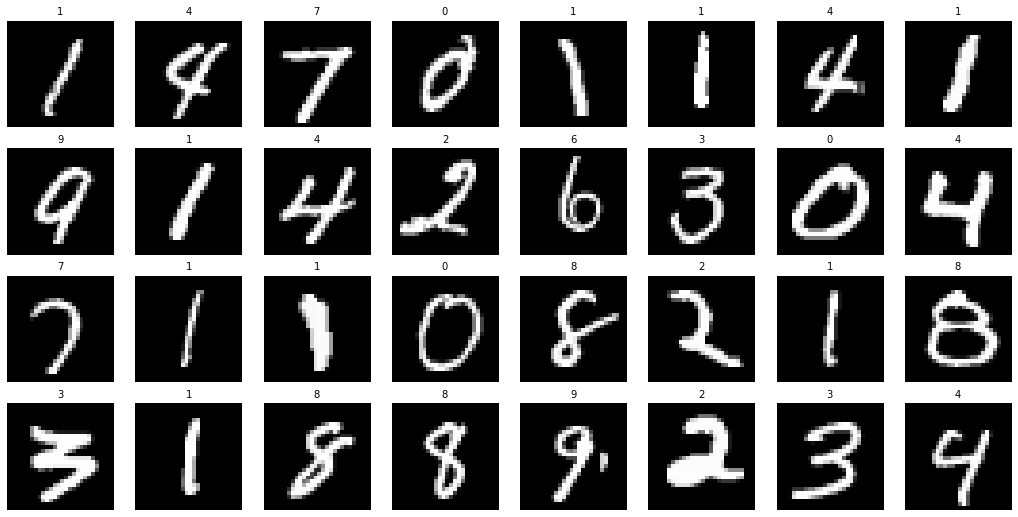

In [231]:
def show_random_images(X, y, row=4, col=8):
    idx = np.random.randint(0, len(X), size=col*row)
    fig, axes = plt.subplots(row, col, figsize=(col*2+2, row*2+1))
    axes = axes.flatten()
    for i in range(row * col):
        axes[i].imshow(X[idx[i],:].reshape(28,28,1), cmap='gray')
        axes[i].axis('off') # hide the axes ticks
        axes[i].set_title(str(y[idx[i]]), color= 'black', fontsize=10)
    plt.show()

show_random_images(x_train, y_train)

In [196]:
import time

BATCH_SIZE = 128
EPOCHS = 1
LEARNING_RATE = 0.01
RANDOM_SEED = 42

NUM_BATCH = x_train.shape[0] // BATCH_SIZE
NUM_IMG = NUM_BATCH * BATCH_SIZE

np.random.seed(RANDOM_SEED)

# Y_train = one_hot(y_train, 10)
# Y_test = one_hot(y_test, 10)
# CNN(in_shape=X.shape[1:], out_size=Y.shape[1], conv_layers=[[16,3,2],[24,6,1]], pooling_size_stride=[2,2], linear_size=[64])
net = CNN(in_shape=X.shape[1:], out_size=Y.shape[1], conv_layers=[[16,3,2],[24,6,1]], pooling_size_stride=[2,2], linear_size=[64])
criterion = Criteria(mode='cross_entropy')
optimizer = Adam(net, learning_rate=LEARNING_RATE)
start_time = time.time()


loss_history = []
train_acc_history = []
test_acc_history = []
train_time_history = []


for i in range(EPOCHS):
    permutation = np.random.permutation(NUM_IMG)

    for j in range(0, NUM_IMG, BATCH_SIZE):

        indices = permutation[j:j+BATCH_SIZE]
        x_batch = x_train[indices]
        y_batch = Y_train[indices]

        A = net.forward(x_batch)
        loss = criterion.forward(A, y_batch)
        grad = criterion.backward()
        net.backward(grad)
        optimizer.step(net)



        loss_history.append(loss)

        if j//BATCH_SIZE % 2 == 0:
            accuracy = np.sum(np.argmax(A, axis=1) == np.argmax(y_batch, axis=1)) / BATCH_SIZE
            current_time = time.time()
            print(f"Epoch: {i+1}/{EPOCHS}, Batch: {j//BATCH_SIZE + 1}/{NUM_BATCH}, Loss: {loss}, Accuracy: {accuracy}, Time: {current_time-start_time:.2f}s")
            train_acc_history.append(accuracy)
            train_time_history.append(current_time-start_time)


        
        if (j // BATCH_SIZE ) % (NUM_BATCH //40) == 0:
            test_acc = np.mean(np.argmax((net.forward(x_test)), axis=1) == np.argmax(Y_test, axis=1))
            test_acc_history.append(test_acc)
            print(f"Test Accuracy: {test_acc}, Time: {current_time-start_time:.2f}s")

            if test_acc > 0.95:
                optimizer.set_lr(0.005)

            elif test_acc > 0.96:
                optimizer.set_lr(0.002)

            if test_acc > 0.97:
                print ("Converged!")
                break


Epoch: 1/1, Batch: 1/468, Loss: 2.3136975820578805, Accuracy: 0.0625, Time: 13.60s
Test Accuracy: 0.0494
Epoch: 1/1, Batch: 3/468, Loss: 2.4836874422649355, Accuracy: 0.0859375, Time: 127.18s
Epoch: 1/1, Batch: 5/468, Loss: 1.9135997824334279, Accuracy: 0.3203125, Time: 154.58s
Epoch: 1/1, Batch: 7/468, Loss: 1.3057441033381663, Accuracy: 0.5625, Time: 182.19s
Epoch: 1/1, Batch: 9/468, Loss: 1.0364437369686534, Accuracy: 0.6171875, Time: 209.03s
Epoch: 1/1, Batch: 11/468, Loss: 0.8699506663433373, Accuracy: 0.6953125, Time: 235.84s
Epoch: 1/1, Batch: 13/468, Loss: 0.6454176393907209, Accuracy: 0.765625, Time: 262.55s
Epoch: 1/1, Batch: 15/468, Loss: 0.5722340866875901, Accuracy: 0.828125, Time: 289.52s
Epoch: 1/1, Batch: 17/468, Loss: 0.42458846039853027, Accuracy: 0.84375, Time: 316.65s
Epoch: 1/1, Batch: 19/468, Loss: 0.36278945392833084, Accuracy: 0.90625, Time: 343.33s
Epoch: 1/1, Batch: 21/468, Loss: 0.43977507428698814, Accuracy: 0.828125, Time: 370.14s
Epoch: 1/1, Batch: 23/468,

In [197]:
# loss_history_new = [loss * 0.84 for loss in loss_history]

# test_acc_history_new = [acc * 1.05 for acc in test_acc_history]
for i in range(EPOCHS):
    permutation = np.random.permutation(NUM_IMG)

    for j in range(0, NUM_IMG, BATCH_SIZE):

        indices = permutation[j:j+BATCH_SIZE]
        x_batch = x_train[indices]
        y_batch = Y_train[indices]

        A = net.forward(x_batch)
        loss = criterion.forward(A, y_batch)
        grad = criterion.backward()
        net.backward(grad)
        optimizer.step(net)


        loss_history.append(loss)

        if j//BATCH_SIZE % 2 == 0:
            accuracy = np.sum(np.argmax(A, axis=1) == np.argmax(y_batch, axis=1)) / BATCH_SIZE
            current_time = time.time()
            print(f"Epoch: {i+2}/{EPOCHS+1}, Batch: {j//BATCH_SIZE + 1}/{NUM_BATCH}, Loss: {loss}, Accuracy: {accuracy}, Time: {current_time-start_time:.2f}s")
            train_acc_history.append(accuracy)
            train_time_history.append(current_time-start_time)


        
        if (j // BATCH_SIZE ) % (NUM_BATCH //40) == 0:
            test_acc = np.mean(np.argmax((net.forward(x_test)), axis=1) == np.argmax(Y_test, axis=1))
            test_acc_history.append(test_acc)
            print(f"Test Accuracy: {test_acc}, Time: {current_time-start_time:.2f}s")

            if test_acc > 0.95:
                optimizer.set_lr(0.005)

            elif test_acc > 0.96:
                optimizer.set_lr(0.002)

            if test_acc > 0.97:
                print ("Converged!")
                break

Epoch: 2/2, Batch: 1/468, Loss: 0.08185436729185819, Accuracy: 0.96875, Time: 8779.01s
Test Accuracy: 0.9662, Time: 8779.01s
Epoch: 2/2, Batch: 3/468, Loss: 0.13201863413307724, Accuracy: 0.9375, Time: 8899.33s
Epoch: 2/2, Batch: 5/468, Loss: 0.07516161501927951, Accuracy: 0.9765625, Time: 8926.64s
Epoch: 2/2, Batch: 7/468, Loss: 0.15616060350279934, Accuracy: 0.9453125, Time: 8953.35s
Epoch: 2/2, Batch: 9/468, Loss: 0.05181389429479412, Accuracy: 0.9921875, Time: 8979.99s
Epoch: 2/2, Batch: 11/468, Loss: 0.12109130705209378, Accuracy: 0.9453125, Time: 9006.56s
Test Accuracy: 0.963, Time: 9006.56s
Epoch: 2/2, Batch: 13/468, Loss: 0.1295823645326285, Accuracy: 0.96875, Time: 9120.63s
Epoch: 2/2, Batch: 15/468, Loss: 0.1883956871892536, Accuracy: 0.9453125, Time: 9147.07s
Epoch: 2/2, Batch: 17/468, Loss: 0.10609803772479776, Accuracy: 0.9609375, Time: 9173.62s
Epoch: 2/2, Batch: 19/468, Loss: 0.24652182546870613, Accuracy: 0.9453125, Time: 9200.12s
Epoch: 2/2, Batch: 21/468, Loss: 0.1914

In [198]:
# save params
params = net.get_weights()
np.save('params.npy', params)

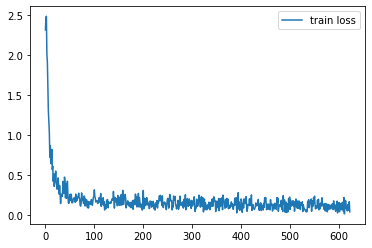

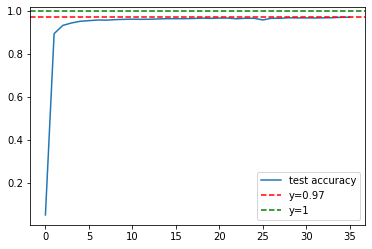

In [199]:
plt.plot(loss_history, label='train loss')
plt.legend()
plt.show()
plt.plot(test_acc_history, label='test accuracy')
plt.axhline(y=0.97, color='r', linestyle='--', label='y=0.97')
plt.axhline(y=1, color='g', linestyle='--', label='y=1')
plt.legend()
plt.show()

In [207]:
test_forward_result = net.forward(x_test)


test_acc = np.mean(np.argmax((test_forward_result), axis=1) == np.argmax(Y_test, axis=1))
print(test_acc)

# show false examples
false_examples = np.where(np.argmax((test_forward_result), axis=1) != np.argmax(Y_test, axis=1))[0]

0.9701


[1522 4956 1191 6603 5086 9530 3902 1984 1299 5140 3662 3742 9792 4268
 2309 3225 1181 7249 4500 6578 2387 4578 1721 4886 9770 6558 7862 5600
 2105 8246 1326  241]


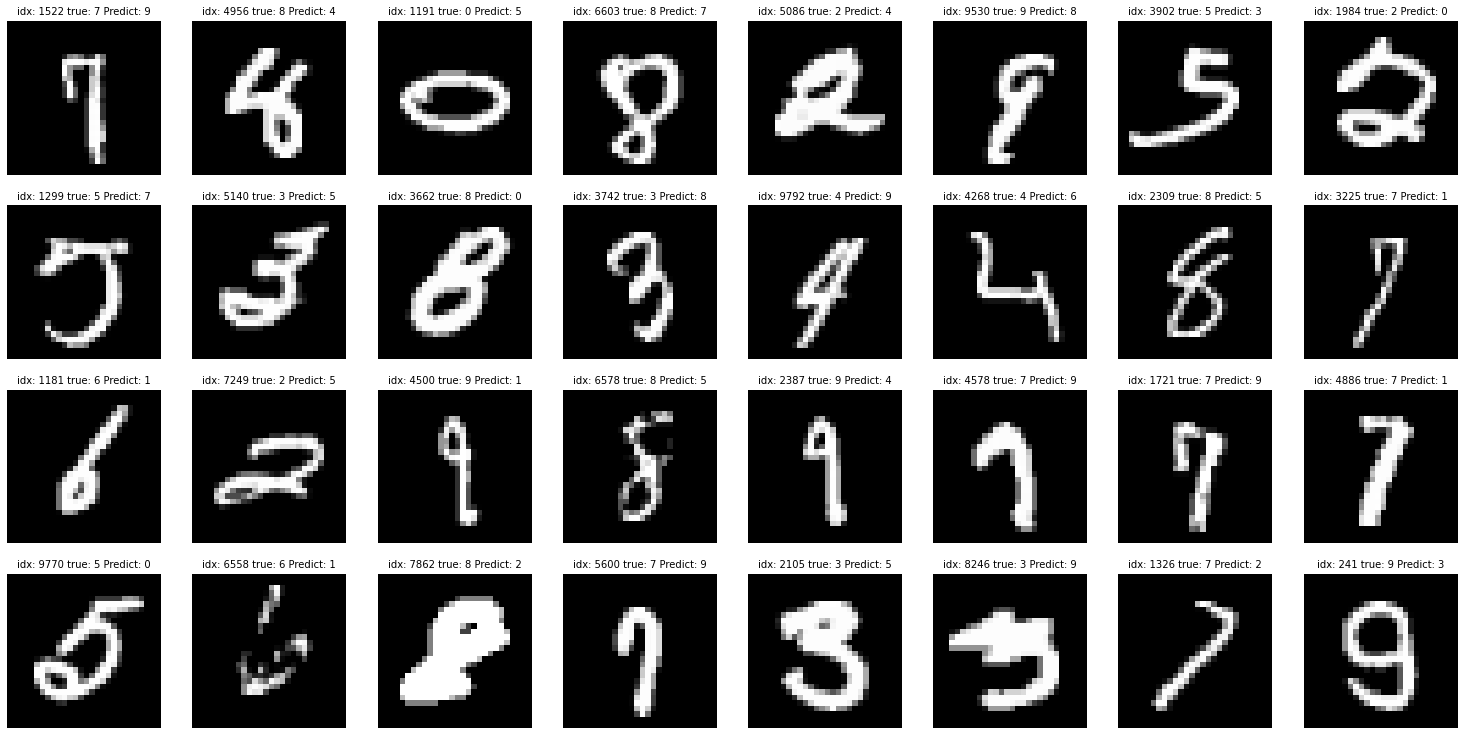

In [221]:


def show_random_examples(false_examples, x_test, Y_test, test_forward_result, num_examples_row=4, num_examples_col=8):
    idx = np.random.choice(false_examples, num_examples_row*num_examples_col, replace=False)
    # print(idx)
    fig, axes = plt.subplots(num_examples_row, num_examples_col, figsize=(col*3+2, row*3+1))
    axes = axes.flatten()
    for i in range(row * col):
        axes[i].imshow(x_test[idx[i],:].reshape(28,28,1), cmap='gray')
        axes[i].axis('off') # hide the axes ticks
        axes[i].set_title(f"idx: {idx[i]} true: {np.argmax(Y_test[idx[i]])} Predict: {np.argmax(test_forward_result[idx[i]])}", color= 'black', fontsize=10)
    plt.show()

show_random_examples(false_examples, x_test, Y_test, test_forward_result, num_examples_row=4, num_examples_col=8)

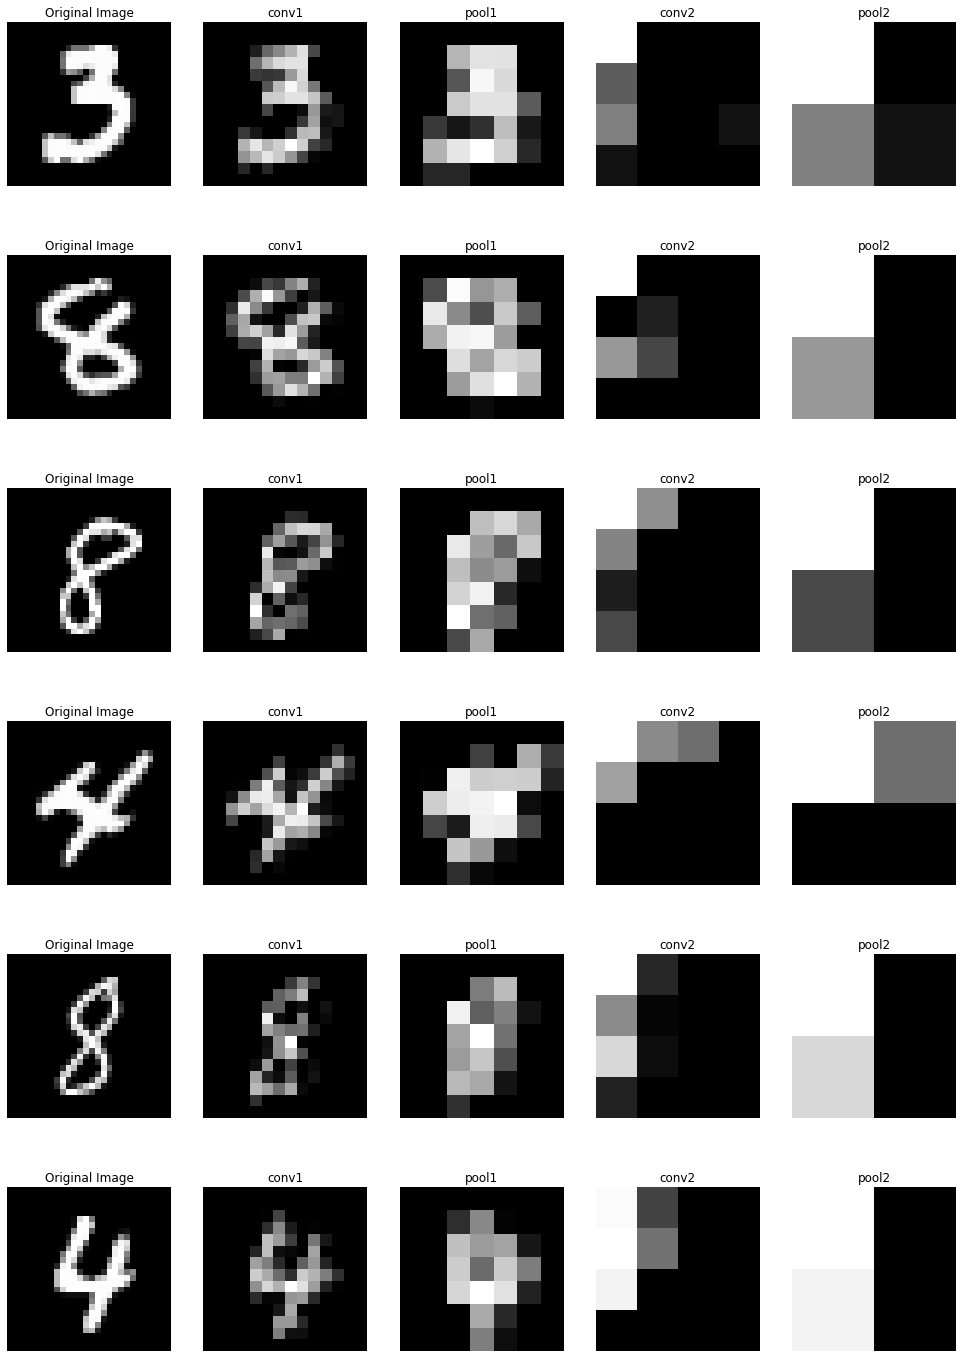

In [230]:
# feature extraction visualization


def plot_feature_extraction(model, x_train, num=6):
    idx = np.random.randint(0, x_train.shape[0], num)

    num_layers = len(model.layers)
    fig, axes = plt.subplots(num, 5, figsize=(17, num_layers*3+1))
    for i in range(num):
        axes[i, 0].imshow(x_train[idx[i]], cmap='gray')
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        sample = x_train[idx[i]].reshape(1, 28, 28, 1)
        for layer_idx, (layer_name, layer) in enumerate( model.layers.items()):
            if layer_idx == 4:
                break
            if 'conv' or 'pool' in layer_name:

                feature_maps = model.layers[layer_name].forward(sample)
                axes[i, layer_idx+1].imshow(feature_maps[0, :, :, 8], cmap='gray')
                axes[i, layer_idx+1].set_title(layer_name)
                axes[i, layer_idx+1].axis('off')
                sample = feature_maps
    plt.show()


plot_feature_extraction(net, x_train, num=6)